## 목표
---
### 공통
**1. CSR matrix가 정상적으로 만들어졌다.**  
    - 사용자와 아이템 개수를 바탕으로 정확한 사이즈로 만들었다.

**2. MF 모델이 정상적으로 훈련되어 그럴듯한 추천이 이루어졌다.**  
    - 사용자와 아이템 벡터 내적수치가 의미있게 형성되었다.

**3. 비슷한 영화 찾기와 유저에게 추천하기의 과정이 정상적으로 진행되었다.**  
    - MF모델이 예측한 유저 선호도 및 아이템간 유사도, 기여도가 의미있게 측정되었다.

---
### 개인
1. 하이퍼 파라미터를 변경하며 학습변화
    - factor를 고정하고 **iteration, regularization 값 변화에 따른 값** 확인
    - iteration, regularization를 고정하고 factor 값 변화에 따른 값 확인
    - 추가 파라미터인 calculate_training_loss 추가 

2. 먼저 **유저별 영화 추천, 좋아하는 영화별 영화 추천** 진행 
    - 유저 정보가 없는 신규 유저를 위해, 가입시 입력되는 **연령대를 통한 영화추천**


## STEP 0. 라이브러리 설정하기
--- 

implicit가 코랩에서 import 되지 않아 따로 다운받아준다.  
- [참고 github](https://github.com/benfred/implicit/issues/160)

In [ ]:
!pip install implicit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.5 MB 4.2 MB/s 


In [ ]:
import numpy as np
import scipy
import implicit
import os
import pandas as pd
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares

In [ ]:
# 구드 연결
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## STEP 1. 데이터 준비와 전처리 
---
- 이번에 활용할 데이터셋은 추천 시스템의 MNIST라고 부를만한 Movielens 데이터입니다.  
- Movielens 데이터는 rating.dat 안에 이미 인덱싱까지 완료된 사용자-영화-평점 데이터가 깔끔하게 정리되어 있으니 불러와 줍니다.


- data 설명
    - 약 3,900편의 영화에 대한 1,000,209개의 익명 등급이 포함됨
    - 2000년에 MovieLens에 가입한 6,040명의 MovieLens 사용자가 만듦
    - 사용자 ID 범위 : 1 ~ 6040
    - MovieID 범위 :  1 ~ 3952
    - 등급 : 별 5개 척도
    - 타임스탬프 : time(2)에 의해 반환된 epoch 이후 초 단위로 표시됩니다. -> 필요없으니 삭제 예정
    - 각 사용자는 최소 20개의 평가를 가지고 있음



In [ ]:
############ 데이터 로드 ###############
path = '/content/drive/MyDrive/COLAB_data/recommend_movie/'

rating_file_path = path + 'ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']

ratings = pd.read_csv(rating_file_path, sep = '::', names = ratings_cols, 
                      engine = 'python', encoding = 'ISO-8859-1')

original_data_size = len(ratings)
ratings.head()

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


유저가 3점 미만으로 준 데이터는 보통 이하이므로 선호하지 않는다고 가정하고 제외하고, 사용하지 않는 timestamp 칼럼도 제거해준다.  

- 이렇게 별점이 아닌 선호/비선호로 나누는 것을 Implicit feed back이라고 하고, 별점같은 수치값으로 나누는 것을 Explicit feed back이라고 한다.  
- 현실에는 구매/비구매, 시청/미시청, 클릭/비클릭 처럼 implicit 데이터를 바탕으로 추천을하는 것이 많음.
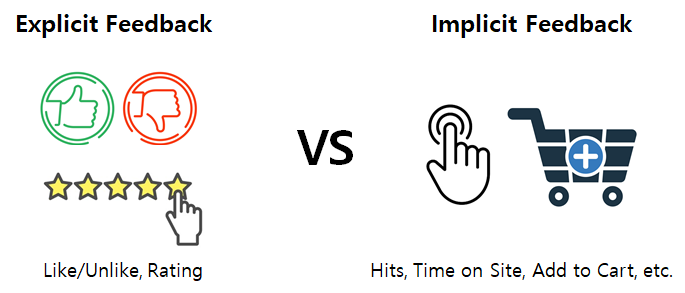

In [ ]:
ratings = ratings[ratings['ratings'] >= 3]
filtered_data_size = len(ratings)

print('원본 size : ', original_data_size, '\n3점 미만 제외 size : ', filtered_data_size)
print('남은 데이터의 비율 : {:.2%}'.format((filtered_data_size / original_data_size)))

원본 size :  1000209 
3점 미만 제외 size :  836478
남은 데이터의 비율 : 83.63%


약 83%는 선호 데이터로 확보했다. 

In [ ]:
# ratings 컬럼의 이름을 counts로 바꿉니다.
ratings.rename(columns = {'ratings' : 'counts'}, inplace = True)

In [ ]:
#잘 바뀌었나 확인
ratings['counts']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: counts, Length: 836478, dtype: int64

In [ ]:
using_cols = ['user_id', 'movie_id', 'counts']
ratings = ratings[using_cols]

ratings.head()

,user_id,movie_id,counts
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [ ]:
# 영화 특성을 보기 위해 movie 데이터를 읽어옵니다.
movie_file_path = path + 'movies.dat'

cols = ['movie_id', 'title', 'genre']
movies = pd.read_csv(movie_file_path, sep = '::', names=cols,
                     engine='python', encoding='ISO-8859-1')

movies.head(50)

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


## STEP 2. TEST용 유저 추가
---

후에 모델의 성능을 확인하기 위해 TEST user 'chaaaaabbo'를 만들어 넣어줍니다.   

user_id 가 6040까지 있으니, chaaaaabbo의 user_id는 6041, 좋아하는 영화는 Toy Story(1) 5점, Pocahontas(48) 4점, Matrix, The (1999)' 5점,'Jurassic Park (1993)' 4점으로 줘보겠습니다. 

In [ ]:
# 좋아하는 영화를 넣어줍니다. 

my_favorite = ['Toy Story (1995)', 'Pocahontas (1995)' ,'Matrix, The (1999)','Jurassic Park (1993)']

for i in my_favorite:
    condition = (movies.title == i)
    print(movies.loc[condition])
# for i in my_favorite:
#     print(i)
#     a = movies.loc[movies['title']==i]
#     print(a)

   movie_id             title                        genre
0         1  Toy Story (1995)  Animation|Children's|Comedy
    movie_id              title                                 genre
47        48  Pocahontas (1995)  Animation|Children's|Musical|Romance
      movie_id               title                   genre
2502      2571  Matrix, The (1999)  Action|Sci-Fi|Thriller
     movie_id                 title                    genre
476       480  Jurassic Park (1993)  Action|Adventure|Sci-Fi


In [ ]:
# 좋아하는 영화 입력

# my_favorite = ['Toy Story (1995)', 'Pocahontas (1995)' ,'Matrix, The (1999)','Jurassic Park (1993)']
my_favorite_movie_id = [1, 48, 2571, 480]

# 'chaaaaabbo'이라는 user_id 특성 입력
my_playlist = pd.DataFrame({'user_id' : ['6041']*4, 'movie_id' : my_favorite_movie_id, 'counts':(5,4,5,4)})

# user_id에 'chaaaaabbo'이라는 데이터가 없다면
if not ratings.isin({'user_id': ['6041']})['user_id'].any():
 # 위에 임의로 만든 my_playlist 데이터를 추가해 줍니다. 
    ratings = ratings.append(my_playlist)

#잘 만들어졌는지 확인
ratings.tail(10)

,user_id,movie_id,counts
1000202,6040,1089,4
1000203,6040,1090,3
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4
1000208,6040,1097,4
0,6041,1,5
1,6041,48,4
2,6041,2571,5
3,6041,480,4


가독성을 위해 movie_id 별 title을 넣어줍니다. 

In [ ]:
############### 유저 정보와 영화 정보를 movie_id를 기준으로 합쳐줌 ############
rating_movie = pd.merge(ratings, movies, how='outer')


In [ ]:
rating_movie.isna().sum()

user_id     255
movie_id      0
counts      255
title         0
genre         0
dtype: int64

user_id와 counts가 없는 영화는 필요없으니 삭제해줍니다. 

In [ ]:
rating_movie = rating_movie.dropna()

rating_movie.isna().sum()

user_id     0
movie_id    0
counts      0
title       0
genre       0
dtype: int64

In [ ]:
rating_movie.tail()

,user_id,movie_id,counts,title,genre
836477,5851,3607,5.0,One Little Indian (1973),Comedy|Drama|Western
836478,5854,3026,4.0,Slaughterhouse (1987),Horror
836479,5854,690,3.0,"Promise, The (Versprechen, Das) (1994)",Romance
836480,5938,2909,4.0,"Five Wives, Three Secretaries and Me (1998)",Documentary
836481,5948,1360,5.0,Identification of a Woman (Identificazione di ...,Drama


## STEP 3. 데이터 분석
---
- ratings에 있는 유니크한 영화 개수
- ratings에 있는 유니크한 사용자 수
- 가장 인기 있는 영화 30개(인기순)
를 한번 뽑아보도록 하겠습니다. 

In [ ]:
################# 영화 유니크 값 확인 ##################
rating_movie['movie_id'].value_counts()

2858    3211
260     2910
1196    2885
1210    2716
2028    2561
        ... 
2556       1
1062       1
821        1
1830       1
1360       1
Name: movie_id, Length: 3628, dtype: int64

In [ ]:
################# user 유니크 값 확인 ##################
rating_movie['user_id'].value_counts()

4169    1968
4277    1715
1680    1515
3618    1146
1015    1145
        ... 
1102       9
4365       9
4349       7
6041       4
4486       1
Name: user_id, Length: 6040, dtype: int64

In [ ]:
##################### 인기 많은 영화 #####################
movie_count = rating_movie.groupby('title')['user_id'].count()
movie_count.sort_values(ascending = False).head(30)

title
American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Terminator 2: Judgment Day (1991)                        2509
Silence of the Lambs, The (1991)                         2498
Raiders of the Lost Ark (1981)                           2473
Back to the Future (1985)                                2460
Matrix, The (1999)                                       2435
Jurassic Park (1993)                                     2414
Sixth Sense, The (1999)                                  2385
Fargo (1996)                                             2371
Braveheart (1995)                                        2314
Men in Black (1997)                                      2297
Schindler's List (1993)                                  2257
Pr

1회만 추천받은 영화 비율 한번 확인해볼까요?

In [ ]:
################## 1회만 추천한 영화의 비율 ##############

only_one = movie_count < 2

one, all_data = len(only_one), len(rating_movie)

print(f'one : {one}, all_data:{all_data}')
print(f'Ratio of only_one over all data is {one/all_data:.2%}')

one : 3628, all_data:836482
Ratio of only_one over all data is 0.43%


0.43% 밖에 안되네요

- 신규 user인 chaaaaabbo가 6041로 잘 들어가있는 것이 보입니다.   

- 그리고 여러 조건별로 데이터를 확인해보았습니다. 

- 그럼 유저별 영화 별점 정보를 통해 선호도를 계산할 수 있게 되었으니 전처리를 끝내고 모델을 설정해봅니다.   

- ~~원래는 id to index, movie to index를 만들어야하지만, 이미 user_id와 movie_id로 잘 들어가 있으니 바로 모델 생성으로 넘어가겠습니다.~~ 
- 처음에 별점 낮은 것을 삭제하면서 id에 공백이 생겼으니 다시 indexing 해줍니다.

## STEP 4. CSR matrix 만들어보기
--- 
- 이번에 사용할 모델은 추천 시스템의 Matrix Factorization(MF, 행렬 분해) 모델 중 CSR Matrix입니다. 
- CSR(Compressed Sparse Row) Matrix는 평가 행렬의 용량이 커짐에 따라 메모리 낭비를 최소화하기 위해서 사용하는 방법입니다. 
- CSR Matrix는 data, indices, indptr 로 행렬을 압축하여 표현합니다. 
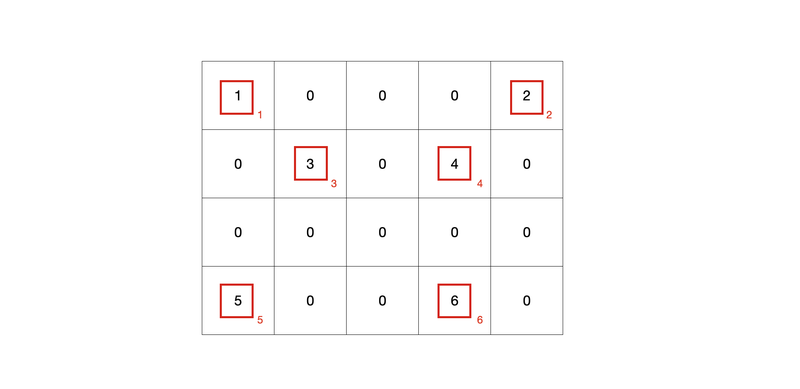

    - data는 0이 아닌 원소를 차례로 기입한 값입니다.
    - indices는 data의 각 요소가 어느 열(column)에 있는지를 표현한 index입니다.
    - indptr은 [최초시작행번호,시작행에서의 데이타 개수,두번째 행에서의 데이타 누적 개수,...,마지막행에서의 데이타 누적개수] 입니다. 이를 통해 data의 요소들이 어느 행(row)에 있는지를 알 수 있습니다.


각 유저와 영화의 고유한 인덱싱을 다시 부여해줍니다 .

In [ ]:
########### 고유한 유저, 영화 찾기 ###############
user_unique = rating_movie['user_id'].unique()
title_unique = rating_movie['title'].unique()

In [ ]:
########### 유저, 영화 indexing ############
user_to_idx = {value:key for key, value in enumerate(user_unique)}
title_to_idx = {value:key for key, value in enumerate(title_unique)}

In [ ]:
# 인덱싱이 잘 되었는지 확인해 봅니다.  
print(title_to_idx['Pulp Fiction (1994)'])

222


In [ ]:
########### indexing을 통해 데이터 컬럼 내 값을 바꾸기 ################

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 

temp_user_data = rating_movie['user_id'].map(user_to_idx.get).dropna()
 # 모든 row가 정상적으로 인덱싱되었다면
if len(temp_user_data) == len(rating_movie):
    print('user_id column indexing OK :)')
    # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
    rating_movie['user_id'] = temp_user_data
else:
    print('user_id column indexing Fail :(')

    

user_id column indexing OK :)


In [ ]:
# title_to_idx을 통해 title 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_title_data = rating_movie['title'].map(title_to_idx.get).dropna()

if len(temp_title_data) == len(rating_movie):
    print('title column indexing OK :)')
    rating_movie['title'] = temp_title_data
else:
    print('title column indexing Fail :(')
    
rating_movie

title column indexing OK :)


,user_id,movie_id,counts,title,genre
0,0,1193,5.0,0,Drama
1,1,1193,5.0,0,Drama
2,2,1193,4.0,0,Drama
3,3,1193,4.0,0,Drama
4,4,1193,5.0,0,Drama
...,...,...,...,...,...
836477,1621,3607,5.0,3623,Comedy|Drama|Western
836478,3481,3026,4.0,3624,Horror
836479,3481,690,3.0,3625,Romance
836480,4159,2909,4.0,3626,Documentary


In [ ]:
############# CSR 데이터 만들기 ###############
num_user = rating_movie['user_id'].nunique()
num_title = rating_movie['title'].nunique()

csr_data = csr_matrix((rating_movie.counts, (rating_movie.user_id, rating_movie.title)), 
                      shape= (num_user, num_title))

csr_data

<6040x3628 sparse matrix of type '<class 'numpy.float64'>'
	with 836482 stored elements in Compressed Sparse Row format>

## STEP 5. als_model = AlternatingLeastSquares 모델 훈련시키기
---
- implicit 패키지는 이전 스텝에서 설명한 암묵적(implicit) dataset을 사용하는 다양한 모델을 굉장히 빠르게 학습할 수 있는 패키지
- 이 패키지에 구현된 als(AlternatingLeastSquares) 모델을 사용하겠습니다. Matrix Factorization에서 쪼개진 두 Feature Matrix를 한꺼번에 훈련하는 것은 잘 수렴하지 않기 때문에, 한쪽을 고정시키고 다른 쪽을 학습하는 방식을 번갈아 수행하는 AlternatingLeastSquares 방식이 효과적인 것으로 알려져 있다. 

- [ALS model 참고 블로그](https://sungkee-book.tistory.com/13)

- AlternatingLeastSquares 클래스의 __init__ 파라미터
    1. factors : 유저와 아이템의 벡터를 몇 차원으로 할 것인지
    2. regularization : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지
    3. use_gpu : GPU를 사용할 것인지
    4. iterations : epochs와 같은 의미입니다. 데이터를 몇 번 반복해서 학습할 것인지
-1과 4를 늘릴수록 학습 데이터를 잘 학습하게 되지만 과적합의 우려가 있으니 좋은 값을 찾아야 합니다.

In [ ]:
# implicit 라이브러리에서 권장하고 있는 부분
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [ ]:
########### Implicit AlternatingLeastSquares 모델 구현 ###########

als_model_1 = AlternatingLeastSquares(factors = 100, regularization = 0.01, 
                                   use_gpu=False, iterations=30, dtype=np.float32)
                                   

In [ ]:
############# 모델 훈련 #############
als_model_1.fit(csr_data)

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
chabo, Jurassic_Park = user_to_idx['6041'], title_to_idx['Jurassic Park (1993)']

chabo_vector, Jurassic_Park_vector = als_model_1.user_factors[chabo], als_model_1.item_factors[Jurassic_Park]

print('과연?')

과연?


In [ ]:
print('차보벡터 : ',chabo_vector)
print('쥬라기 공원 벡터 : ', Jurassic_Park_vector)

차보벡터 :  [ 0.08977108  0.1589569   0.24308142 -0.5053194   0.3215892   0.10557011
  0.08306044  0.5470784   0.16754852  0.4168706  -0.20336238 -0.24214567
 -0.31814516  0.12849803 -1.264669    0.31450093 -0.38113794  0.7506085
 -0.05471826  0.09939356  0.1993841  -0.17010528 -0.17442445  0.09915668
  0.02169737  0.16903251 -0.07233693  0.3114778  -0.45485476 -0.46799812
  0.08804571 -0.83905584 -0.12836288 -0.3755428  -0.42413098 -0.41699815
  0.12717165 -0.16817877  0.20160046  0.23036404  0.4108195  -0.2746147
 -0.4304853   0.3577868   0.29895383  0.08497064  0.44677803  0.24996668
 -0.16378419  0.04399607 -0.01974928  0.382007    0.49134856  0.55766463
 -0.35218754  0.21285789 -0.18709098 -0.33530194 -0.2259531   0.18690144
 -0.38523623 -0.37497103  0.24939449  0.27616355  0.5191493  -0.16484115
  0.4825321  -0.5162852  -0.28268942  0.02415121 -0.32644445  0.03629114
  0.40251428  0.7449067  -0.12120294 -0.03862991 -0.18928075 -0.17755762
 -0.08113124  0.24575886  0.33399466  0.31247

In [ ]:
# 차보와 쥬라기공원을 내적하는 코드
np.dot(chabo_vector, Jurassic_Park_vector)

0.5067376

흠.... 원래 1이 나와야하는데, 아직 0.5밖에 나오지 않는다.   

모델을 바꿔주자

### 모델 변형 1 (iterater 비교)
---
- factor는 100 그대로 두고, iterator를 100으로 올려보자. 대신 regulation을 0.05로 높여준다. 

In [ ]:
########### Implicit AlternatingLeastSquares 모델 구현 2번째###########

als_model_2 = AlternatingLeastSquares(factors = 100, regularization = 0.05, 
                                   use_gpu=False, iterations=100, dtype=np.float32)

############# 모델 훈련 #############
als_model_2.fit(csr_data)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
def dot(user_to_id, title_to_id):
    chabo, movie_title = user_to_idx[user_to_id], title_to_idx[title_to_id]
    chabo_vector, movie_title_vector = als_model_2.user_factors[chabo], als_model_2.item_factors[movie_title]
    dot = np.dot(chabo_vector, movie_title_vector)

    Black = title_to_idx['Men in Black (1997)']
    Black_vector = als_model_2.item_factors[Black]
    dot2 = np.dot(chabo_vector, Black_vector)

    return print('내적값은 {:.2}입니다. \nMen in Black의 내적값은 {:.2}입니다'.format(dot, dot2))



In [ ]:
dot('6041', 'Jurassic Park (1993)')
dot('6041', 'Toy Story (1995)')

내적값은 0.52입니다. 
Men in Black의 내적값은 0.43입니다
내적값은 0.48입니다. 
Men in Black의 내적값은 0.43입니다


아주 살짝 높아졌다.... 흠

## STEP 6. 선호 영화 하나와 다른 영화 하나 골라 훈련된 모델이 예측한 나의 선호도 확인
---

#### 모델 변형 1-2 (iterater 비교)
---
- factor는 100 그대로 두고, iterator를 1000 으로 올려보자. 대신 regulation을 0.1로 높여준다. 

- 그리고 다른 영화의 선호도도 같이 예측할 수 있도록 확인해서 모델이 잘 돌아가는지 확인해보자. 

- 참고로 다른 영화는 Men in Black으로 보고 싶은 영화중에 하나다! 

In [ ]:
########### Implicit AlternatingLeastSquares 모델 구현 3번째###########

als_model_3 = AlternatingLeastSquares(factors = 100, regularization = 0.1, 
                                   use_gpu=False, iterations=1000, dtype=np.float32)

############# 모델 훈련 #############
als_model_3.fit(csr_data)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
def dot(user_to_id, title_to_id):
    chabo, movie_title = user_to_idx[user_to_id], title_to_idx[title_to_id]
    chabo_vector, movie_title_vector = als_model_3.user_factors[chabo], als_model_3.item_factors[movie_title]
    dot = np.dot(chabo_vector, movie_title_vector)

    Black = title_to_idx['Men in Black (1997)']
    Black_vector = als_model_3.item_factors[Black]
    dot2 = np.dot(chabo_vector, Black_vector)

    return print('내적값은 {:.2}입니다. \nMen in Black의 내적값은 {:.2}입니다'.format(dot, dot2))


In [ ]:
dot('6041', 'Jurassic Park (1993)')
dot('6041', 'Toy Story (1995)')

내적값은 0.52입니다. 
Men in Black의 내적값은 0.42입니다
내적값은 0.49입니다. 
Men in Black의 내적값은 0.42입니다


내적 값이 아주 조금 올라가고 men in black도 나름 내적값이 나쁘지 않다.   

하지만 iter를 올린것에비해 내적값이 많이 올라가지 않는것을 보니 과적합의 의심이들어, regulation 값을 올리고 factor를 낮춰본다.

In [ ]:
########### Implicit AlternatingLeastSquares 모델 구현 4번째###########

als_model_4 = AlternatingLeastSquares(factors = 100, regularization = 0.2, 
                                   use_gpu=False, iterations=1000, dtype=np.float32)

############# 모델 훈련 #############
als_model_4.fit(csr_data)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
def dot(user_to_id, title_to_id):
    chabo, movie_title = user_to_idx[user_to_id], title_to_idx[title_to_id]
    chabo_vector, movie_title_vector = als_model_4.user_factors[chabo], als_model_4.item_factors[movie_title]
    dot = np.dot(chabo_vector, movie_title_vector)

    Black = title_to_idx['Men in Black (1997)']
    Black_vector = als_model_4.item_factors[Black]
    dot2 = np.dot(chabo_vector, Black_vector)

    return print('내적값은 {:.2}입니다. \nMen in Black의 내적값은 {:.2}입니다'.format(dot, dot2))


In [ ]:
dot('6041', 'Jurassic Park (1993)')
dot('6041', 'Toy Story (1995)')

내적값은 0.52입니다. 
Men in Black의 내적값은 0.43입니다
내적값은 0.49입니다. 
Men in Black의 내적값은 0.43입니다


### iteration 값 & regularization 조절 결과
1. fac = 100, reg = 0.05, iter = 30 -> 0.50
2. fac = 100, reg = 0.05, iter = 100 -> 0.52 / 0.43
3. fac = 100, reg = 0.1, iter = 1000 -> 0.52 / 0.42
4.  fac = 100, reg = 0.2, iter = 1000 -> 0.52 / 0.43

- 데이터의 값이 적어서 그런지, iterator를 100 -> 1000으로 무작정 올린다고 비례하게 올라가는 것은 아닌 것 같다.  
    - 좋아하는 영화의 내적 값은 0.52로 동일, 추천은 0.43 - 0.42로 오히려 감소
-  오히려 처음 30 -> 100으로 소폭 증가시켰을 때 시간대비 효율적으로 내적값이 증가하는 것을 볼 수 있다.  
- iter 100 이후 iter 1000, regularization 을 0.05 -> 0.2로 높여봐도 큰 변화 없음. 

**-> 이후 과정은 factor 변경으로 간다.**   


### 모델변형 1-3 (factor 비교)
---
iteration, regularization은 2번으로 고정(reg = 0.05, iter = 100)하고 
1. factor : 100 -> 50 감소
2. factor : 100 -> 200 증가   
regularization : 0.05 -> 0.2 증가 하는 것

상기 2회 테스트를 진행하면서 factor값에 의한 변화를 확인한다. 

In [ ]:
########### Implicit AlternatingLeastSquares 모델 구현 5번째###########

als_model_5 = AlternatingLeastSquares(factors = 50, regularization = 0.05, 
                                   use_gpu=False, iterations = 100, dtype=np.float32)

############# 모델 훈련 #############
als_model_5.fit(csr_data)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
def dot(user_to_id, title_to_id):
    chabo, movie_title = user_to_idx[user_to_id], title_to_idx[title_to_id]
    chabo_vector, movie_title_vector = als_model_5.user_factors[chabo], als_model_5.item_factors[movie_title]
    dot = np.dot(chabo_vector, movie_title_vector)

    Black = title_to_idx['Men in Black (1997)']
    Black_vector = als_model_5.item_factors[Black]
    dot2 = np.dot(chabo_vector, Black_vector)

    return print('내적값은 {:.2}입니다. \nMen in Black의 내적값은 {:.2}입니다'.format(dot, dot2))


dot('6041', 'Jurassic Park (1993)')
dot('6041', 'Toy Story (1995)')

내적값은 0.37입니다. 
Men in Black의 내적값은 0.34입니다
내적값은 0.35입니다. 
Men in Black의 내적값은 0.34입니다


앗..... 처참..... factor는 낮추면 안되는 것 같다.

In [ ]:
########### Implicit AlternatingLeastSquares 모델 구현 6번째###########

als_model_6 = AlternatingLeastSquares(factors = 200, regularization = 0.2, 
                                   use_gpu=False, iterations = 100, dtype=np.float32)

############# 모델 훈련 #############
als_model_6.fit(csr_data)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
def dot(user_to_id, title_to_id):
    chabo, movie_title = user_to_idx[user_to_id], title_to_idx[title_to_id]
    chabo_vector, movie_title_vector = als_model_6.user_factors[chabo], als_model_6.item_factors[movie_title]
    dot = np.dot(chabo_vector, movie_title_vector)

    Black = title_to_idx['Men in Black (1997)']
    Black_vector = als_model_6.item_factors[Black]
    dot2 = np.dot(chabo_vector, Black_vector)

    return print('내적값은 {:.2}입니다. \nMen in Black의 내적값은 {:.2}입니다'.format(dot, dot2))


dot('6041', 'Jurassic Park (1993)')
dot('6041', 'Toy Story (1995)')

내적값은 0.66입니다. 
Men in Black의 내적값은 0.32입니다
내적값은 0.71입니다. 
Men in Black의 내적값은 0.32입니다



- 우선 factor는 100이하로 낮추면 안된다는 것을 알았다...!
- 확실히 factor를 올리니 **좋아하는 영화에대한 내적값이 0.52 -> 0.66로 유의미하게 증가**한 것을 볼 수 있다.
- 하지만 **대조적으로 추천 영화의 내적값은 0.43 -> 0.32로 감소**했다.... 이걸 좋은 변화로 봐도 좋을까 고민이 된다.  
- 오히려 좋아하는 영화에 과적합된건 아닐까 고민이 들어 factor 200고정에, 과적합 방지용 regularization 0.4, iter 200으로 마지막 시도를 해본다...

In [ ]:
########### Implicit AlternatingLeastSquares 모델 구현 7번째###########

als_model_7 = AlternatingLeastSquares(factors = 200, regularization = 0.4, 
                                   use_gpu=False, iterations = 200, dtype=np.float32)

############# 모델 훈련 #############
als_model_7.fit(csr_data)

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
def dot(user_to_id, title_to_id):
    chabo, movie_title = user_to_idx[user_to_id], title_to_idx[title_to_id]
    chabo_vector, movie_title_vector = als_model_7.user_factors[chabo], als_model_7.item_factors[movie_title]
    dot = np.dot(chabo_vector, movie_title_vector)

    Black = title_to_idx['Men in Black (1997)']
    Black_vector = als_model_7.item_factors[Black]
    dot2 = np.dot(chabo_vector, Black_vector)

    return print('내적값은 {:.2}입니다. \nMen in Black의 내적값은 {:.2}입니다'.format(dot, dot2))


dot('6041', 'Jurassic Park (1993)')
dot('6041', 'Toy Story (1995)')

내적값은 0.66입니다. 
Men in Black의 내적값은 0.31입니다
내적값은 0.69입니다. 
Men in Black의 내적값은 0.31입니다


- 추가한번 더...!!!!   
공식문서에 조절할 수 있는 파라미터 값으로 **calculate_training_loss (bool, optional)** – Whether to log out the training loss at each iteration을 제공하길래 한번 True로 적용해서 시도해본다..!

https://implicit.readthedocs.io/en/latest/als.html#implicit.als.AlternatingLeastSquares

In [ ]:
########### Implicit AlternatingLeastSquares 모델 구현 8번째###########

als_model_8 = AlternatingLeastSquares(factors = 150, regularization = 0.4, 
                                   use_gpu=False, iterations = 500, calculate_training_loss = True, dtype=np.float32)

############# 모델 훈련 #############
als_model_8.fit(csr_data)

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
def dot(user_to_id, title_to_id):
    chabo, movie_title = user_to_idx[user_to_id], title_to_idx[title_to_id]
    chabo_vector, movie_title_vector = als_model_8.user_factors[chabo], als_model_8.item_factors[movie_title]
    dot = np.dot(chabo_vector, movie_title_vector)

    Black = title_to_idx['Men in Black (1997)']
    Black_vector = als_model_8.item_factors[Black]
    dot2 = np.dot(chabo_vector, Black_vector)

    return print('내적값은 {:.2}입니다. \nMen in Black의 내적값은 {:.2}입니다'.format(dot, dot2))


dot('6041', 'Jurassic Park (1993)')
dot('6041', 'Toy Story (1995)')

내적값은 0.59입니다. 
Men in Black의 내적값은 0.36입니다
내적값은 0.62입니다. 
Men in Black의 내적값은 0.36입니다


### factor 값 조절 결과
1. (model_2)  
fac = 100, reg = 0.05, iter = 100 -> 0.52 / 0.43
2. fac = 50, reg = 0.05, iter = 100 -> 0.37 / 0.34
3. fac = 200, reg = 0.2, iter = 100 -> 0.66 / 0.32
4. fac = 200, reg = 0.4, iter = 200 -> 0.66 / 0.31
5. fac = 100, reg = 0.4, iter = 500, training_loss = True -> 0.53 / 0.43
6. fac = 150, reg = 0.4, iter = 500, training_loss = True -> 0.59 / 0.36

- 우선 factor는 100이하로 낮추면 안된다는 것을 알았다...!
- 확실히 factor를 올리니 **좋아하는 영화에대한 내적값이 0.52 -> 0.66로 유의미하게 증가**하지만 **대조적으로 추천 영화의 내적값은 0.43 -> 0.32로 감소**했다.... 이걸 좋은 변화로 봐도 좋을까 고민이 된다. 
- 다른 parameter도 넣어보고 다양하게 시도했지만, 결국 과적합으로 이어지는 것 같다.... 

---
- 결국, factor 200은 데이터양 부족인지 계속해서 과적합되는 것으로 볼 수 있을 것 같다... model 2번인 fac = 100, reg = 0.05, iter = 100 값으로 이후 과정을 진행해본다. 


## STEP 7. 내가 좋아하는 영화와 비슷한 영화 추천받기
---
- `AlternatingLeastSquares` 클래스에 구현되어 있는 `similar_items` 메서드를 통하여 비슷한 영화를 찾는다.
- model값은 2번으로 사용함
- 우선 시작은 'Matrix, The (1999)'로 받아본다. 

In [ ]:
############## 추천 영화 및 관련도 #################
favorite_movie = 'Matrix, The (1999)'

title_id = title_to_idx[favorite_movie]
similar_movie_temp = als_model_2.similar_items(title_id, N = 15)
#출력
similar_movie_temp

(array([ 124, 1092,  221, 2135, 2445, 1680,   41, 2317, 1887, 2691, 2243,
        2954, 1911,  204, 2479], dtype=int32),
 array([1.0000001 , 0.85947233, 0.857236  , 0.8547958 , 0.854176  ,
        0.85286057, 0.85154957, 0.85132265, 0.850493  , 0.85037106,
        0.8497094 , 0.84967995, 0.8490014 , 0.8488507 , 0.84883094],
       dtype=float32))

In [ ]:
# 영화 index만 추출하여 리스트로 만들어줌
similar_list = similar_movie_temp[0]
similar_list

array([ 124, 1092,  221, 2135, 2445, 1680,   41, 2317, 1887, 2691, 2243,
       2954, 1911,  204, 2479], dtype=int32)

In [ ]:
############# 추천영화 리스트 출력 ###############

#artist_to_idx 를 뒤집어, index로부터 artist 이름을 얻는 dict를 생성
idx_to_title = {v: k for k, v in title_to_idx.items()}
# 위에서 Matrix로 추천 받은 영화 리스트를 출력
[idx_to_title[i]for i in similar_list]

['Matrix, The (1999)',
 'Thin Blue Line, The (1988)',
 'South Park: Bigger, Longer and Uncut (1999)',
 'Clan of the Cave Bear, The (1986)',
 'Angels and Insects (1995)',
 'Cemetery Man (Dellamorte Dellamore) (1994)',
 'Rain Man (1988)',
 'Burnt By the Sun (Utomlyonnye solntsem) (1994)',
 'Wonder Boys (2000)',
 'Get Carter (1971)',
 'Yards, The (1999)',
 'Groove (2000)',
 'Seven Days in May (1964)',
 'Clueless (1995)',
 'Disturbing Behavior (1998)']

오 매트릭스에 터미네이터, 에일리언, 스타워즈, 식스센스, 페이스오프 추천이라.... 좋네요!!!!캬~ 녀석...! 영화 좀 볼 줄 아네요(흡족)

그럼 함수화하여 좋아하는 영화 리스트로 추천받아 봅시다!

In [ ]:
def similar_movie(favorite_movie : str):
    title_id = title_to_idx[favorite_movie]
    #각 영화당 5개씩만 추천
    similar_movie = als_model_2.similar_items(title_id, N = 5)
    #추천 영화 index -> list로 저장
    similar_movie_list = similar_movie[0]
    #index to title 생성
    idx_to_title = {v: k for k, v in title_to_idx.items()}
    similar_movie = [idx_to_title[i] for i in similar_movie_list]
    return print(f'{favorite_movie}를 좋아하는 당신은 \n{similar_movie}를 좋아할지도 모르겠네요:)!')

similar_movie('Matrix, The (1999)')

Matrix, The (1999)를 좋아하는 당신은 
['Matrix, The (1999)', 'Terminator 2: Judgment Day (1991)', 'Total Recall (1990)', 'Terminator, The (1984)', 'Fugitive, The (1993)']를 좋아할지도 모르겠네요:)!


In [ ]:
########## favorite 영화 리스트별 추천 영화 뽑기 ###############
my_favorite = ['Toy Story (1995)', 'Pocahontas (1995)' ,'Matrix, The (1999)','Jurassic Park (1993)']

for movie_title in my_favorite:
    similar_movie(movie_title)
    print('=='*20, '\n')


Toy Story (1995)를 좋아하는 당신은 
['Toy Story (1995)', 'Toy Story 2 (1999)', "Bug's Life, A (1998)", 'Aladdin (1992)', 'Babe (1995)']를 좋아할지도 모르겠네요:)!

Pocahontas (1995)를 좋아하는 당신은 
['Pocahontas (1995)', 'Hunchback of Notre Dame, The (1996)', 'Hercules (1997)', 'Anastasia (1997)', 'Tarzan (1999)']를 좋아할지도 모르겠네요:)!

Matrix, The (1999)를 좋아하는 당신은 
['Matrix, The (1999)', 'Terminator 2: Judgment Day (1991)', 'Total Recall (1990)', 'Terminator, The (1984)', 'Fugitive, The (1993)']를 좋아할지도 모르겠네요:)!

Jurassic Park (1993)를 좋아하는 당신은 
['Jurassic Park (1993)', 'Men in Black (1997)', 'Terminator 2: Judgment Day (1991)', 'Total Recall (1990)', 'Matrix, The (1999)']를 좋아할지도 모르겠네요:)!



## STEP 8. 내가 좋아할만한 영화 추천받기
---
- 이제 특정 영화에 따른 추천이 아닌, 유저의 특성을 통한 영화를 추천받아보자

- `AlternatingLeastSquares` 클래스에 구현되어 있는 `recommend` 메서드를 통하여 좋아할만한 영화 추천받기
- `filter_already_liked_items` 는 유저가 이미 평가한 아이템은 제외하는 Argument임


In [ ]:
# chaaaaabbo id 입력.... 
user = user_to_idx['6041']

movie_recommended = als_model_2.recommend(user, csr_data[user], N = 20,
                                        filter_already_liked_items = True)
movie_recommended

(array([ 92, 175,  50,  62, 141, 330,  33,  10, 322,  87, 200,   4, 145,
         38, 110, 150,  48, 317,  75, 375], dtype=int32),
 array([0.52726245, 0.43039417, 0.40739787, 0.34148058, 0.29048112,
        0.2701519 , 0.25057358, 0.24149477, 0.23629405, 0.22117597,
        0.21904218, 0.21266264, 0.20762894, 0.2020968 , 0.20144819,
        0.1958574 , 0.17420527, 0.16970347, 0.1685827 , 0.16787098],
       dtype=float32))

In [ ]:
############ 유저별 영화 추천 함수 #############
def movie_recommend(user_index : int):
    movie_recommended = als_model_2.recommend(user, csr_data[user], N = 10,
                                        filter_already_liked_items = True)
    recommended_list = movie_recommended[0]
    recommended_list = [idx_to_title[i] for i in recommended_list]
    print(f'사용자님 안녕하세요^_____^!\n{recommended_list}영화들은 어떠신가요?')

movie_recommend('6041')

사용자님 안녕하세요^_____^!
['Terminator 2: Judgment Day (1991)', 'Men in Black (1997)', 'Toy Story 2 (1999)', 'Total Recall (1990)', 'Fugitive, The (1993)', 'Lion King, The (1994)', 'Aladdin (1992)', 'Beauty and the Beast (1991)', 'Babe (1995)', 'Braveheart (1995)']영화들은 어떠신가요?


In [ ]:
############# 랜덤한 유저들 영화 추천 #############
# 선택받은 5명 뽑기
random_user = np.random.randint(1,num_user, size=5)

for user in random_user:
    movie_recommend(user)
    print('=='*20, '\n')

사용자님 안녕하세요^_____^!
['Jaws (1975)', 'Saving Private Ryan (1998)', 'Butch Cassidy and the Sundance Kid (1969)', 'Star Trek III: The Search for Spock (1984)', 'Rocky (1976)', 'Die Hard (1988)', 'Glory (1989)', 'Close Encounters of the Third Kind (1977)', 'Dirty Dozen, The (1967)', 'Abyss, The (1989)']영화들은 어떠신가요?

사용자님 안녕하세요^_____^!
['Indiana Jones and the Temple of Doom (1984)', 'Highlander (1986)', 'Jurassic Park (1993)', 'Dragonheart (1996)', 'Jumanji (1995)', 'Superman II (1980)', 'Crocodile Dundee (1986)', 'Who Framed Roger Rabbit? (1988)', 'Goonies, The (1985)', "Logan's Run (1976)"]영화들은 어떠신가요?

사용자님 안녕하세요^_____^!
['Philadelphia Story, The (1940)', 'Romancing the Stone (1984)', 'Willy Wonka and the Chocolate Factory (1971)', 'Auntie Mame (1958)', 'Citizen Kane (1941)', 'Babe (1995)', 'Splash (1984)', 'Out of Africa (1985)', 'Lord of the Rings, The (1978)', 'Superman (1978)']영화들은 어떠신가요?

사용자님 안녕하세요^_____^!
['Lethal Weapon 2 (1989)', 'Jaws (1975)', 'Rain Man (1988)', 'Goldfinger (1964)

선택받은 5명이 좋아했으면 좋겠네요^_____^ㅎㅎ..

추가로 아까 추천 받은 영화들 중 `AlternatingLeastSquares` 클래스에 구현된 `explain` 메서드를 사용해 기록을 남긴 데이터 중 추천에 기여한 정도를 확인해보자.

In [ ]:
curious_movie = title_to_idx['Beauty and the Beast (1991)']

explain = als_model_2.explain(user, csr_data, itemid = curious_movie)
explain

(0.13345282420905838,
 [(8, 0.0677257100620382),
  (45, 0.05316036735480158),
  (46, 0.05126707037819418),
  (322, 0.049812594023575116),
  (572, 0.04769705047777745),
  (178, 0.04593842050485995),
  (536, 0.045369720377081924),
  (551, 0.03899697398329021),
  (619, 0.03749149045158364),
  (141, 0.0362110283724336)],
 (array([[ 2.50864761e+00,  3.36006875e-02,  3.88609527e-02, ...,
           4.55737664e-03, -8.16480484e-02, -4.25831986e-04],
         [ 8.42922844e-02,  2.53926375e+00,  1.53191011e-01, ...,
           1.52317732e-01,  4.72703114e-02, -1.66438704e-01],
         [ 9.74884360e-02,  3.90298135e-01,  2.61609177e+00, ...,
           1.61946008e-01, -5.82078498e-02,  1.00452931e-01],
         ...,
         [ 1.14328520e-02,  3.86928026e-01,  4.47176429e-01, ...,
           2.42583600e+00,  5.81354812e-03, -2.76071508e-02],
         [-2.04826181e-01,  1.17288358e-01, -1.48208611e-01, ...,
           1.63976587e-01,  2.44595272e+00, -6.77979978e-02],
         [-1.06826239e-03, 

In [ ]:
[(idx_to_title[i[0]], i[1]) for i in explain[1]]

[('Snow White and the Seven Dwarfs (1937)', 0.0677257100620382),
 ('Mary Poppins (1964)', 0.05316036735480158),
 ('Dumbo (1941)', 0.05126707037819418),
 ('Babe (1995)', 0.049812594023575116),
 ('Sleeping Beauty (1959)', 0.04769705047777745),
 ('Unforgiven (1992)', 0.04593842050485995),
 ('Jungle Book, The (1967)', 0.045369720377081924),
 ('Peter Pan (1953)', 0.03899697398329021),
 ('Alice in Wonderland (1951)', 0.03749149045158364),
 ('Fugitive, The (1993)', 0.0362110283724336)]

추천... 연관도가 다들 굉장히 낮네욤....

## STEP 9. (추가)연령별 영화 추천
---
영화를 통한 추천, 유저의 선택영화를 통한 추천이 가능해졌다.  
하지만 이런 추천은 신규 인원에 대한 추천은 불가능 하다는 단점이 있다. 이것을 보완하기 위해 신규 가입시 생년월일을 기입한다는 것에 착안하여 연령대에 맞춰 영화 추천을 진행해보려고 한다.   

- 유저 관련 정보 
    - columns : UserID, Gender, Age, Occupation, Zip-code
    - Gender : "M" for male, "F" for female
    - Age is chosen from the following ranges:

	    *  1:  "Under 18"
	    * 18:  "18-24"
	    * 25:  "25-34"
	    * 35:  "35-44"
	    * 45:  "45-49"
	    * 50:  "50-55"
	    * 56:  "56+"

    - Occupation is chosen from the following choices:

        *  0:  "other" or not specified
        *  1:  "academic/educator"
        *  2:  "artist"
        *  3:  "clerical/admin"
        *  4:  "college/grad student"
        *  5:  "customer service"
        *  6:  "doctor/health care"
        *  7:  "executive/managerial"
        *  8:  "farmer"
        *  9:  "homemaker"
        * 10:  "K-12 student"
        * 11:  "lawyer"
        * 12:  "programmer"
        * 13:  "retired"
        * 14:  "sales/marketing"
        * 15:  "scientist"
        * 16:  "self-employed"
        * 17:  "technician/engineer"
        * 18:  "tradesman/craftsman"
        * 19:  "unemployed"
        * 20:  "writer"


In [ ]:
############ 유저 데이터 로드 ###############
user_file_path = path + 'users.dat'
user_cols = ['user_id', 'gender', 'age', 'occupation', 'zip-code']
users = pd.read_csv(user_file_path, sep = '::', names = user_cols, 
                      engine = 'python', encoding = 'ISO-8859-1')

original_user_data_size = len(users)
users.head()

,user_id,gender,age,occupation,zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [ ]:
############## zip code 제외 데이터 생성 ##################
using_cols = ['user_id', 'gender', 'age', 'occupation']
users = users[using_cols]

users.head()

,user_id,gender,age,occupation
0,1,F,1,10
1,2,M,56,16
2,3,M,25,15
3,4,M,45,7
4,5,M,25,20


In [ ]:
############### 유저 정보와 영화 정보를 user_id를 기준으로 합쳐줌 ############
user_rating = pd.merge(users, ratings, how='outer')
user_rating.head()

,user_id,gender,age,occupation,movie_id,counts
0,1.0,F,1.0,10.0,1193.0,5.0
1,1.0,F,1.0,10.0,661.0,3.0
2,1.0,F,1.0,10.0,914.0,3.0
3,1.0,F,1.0,10.0,3408.0,4.0
4,1.0,F,1.0,10.0,2355.0,5.0


In [ ]:
# chaaaaabbo 유저의 정보 입력해주기
my_favorite_movie_id = [1, 48, 2571, 480]

# 'chaaaaabbo'이라는 user_id 특성 입력
my_playlist = pd.DataFrame({'user_id' : ['9999']*4, 'movie_id' : my_favorite_movie_id, 'counts':(5,4,5,4), 'gender' : ['F']*4, 'age': [25]*4, 'occupation' : [1]*4 })

# user_id에 'chaaaaabbo'이라는 데이터가 없다면
if not user_rating.isin({'user_id': ['9999']})['user_id'].any():
 # 위에 임의로 만든 my_playlist 데이터를 추가해 줍니다. 
    user_rating = user_rating.append(my_playlist)

#잘 만들어졌는지 확인
user_rating.tail(10)

,user_id,gender,age,occupation,movie_id,counts
836477,6040.0,M,25.0,6.0,1096.0,4.0
836478,6040.0,M,25.0,6.0,1097.0,4.0
836479,6041,NaN,NaN,NaN,1.0,5.0
836480,6041,NaN,NaN,NaN,48.0,4.0
836481,6041,NaN,NaN,NaN,2571.0,5.0
836482,6041,NaN,NaN,NaN,480.0,4.0
0,9999,F,25.0,1.0,1.0,5.0
1,9999,F,25.0,1.0,48.0,4.0
2,9999,F,25.0,1.0,2571.0,5.0
3,9999,F,25.0,1.0,480.0,4.0


In [ ]:
############ 영화 데이터와 merge해주기 ###############
user_movie = pd.merge(user_rating, movies, how='outer')

user_movie.isna().sum()

user_id       255
gender        259
age           259
occupation    259
movie_id        1
counts        256
title           1
genre           1
dtype: int64

In [ ]:
######### null 값 확인 후 dropna 해주기 #############
user_movie = user_movie.dropna()

user_movie.isna().sum()

user_id       0
gender        0
age           0
occupation    0
movie_id      0
counts        0
title         0
genre         0
dtype: int64

In [ ]:
user_movie.head(10)

,user_id,gender,age,occupation,movie_id,counts,title,genre
0,1.0,F,1.0,10.0,1193.0,5.0,One Flew Over the Cuckoo's Nest (1975),Drama
1,2.0,M,56.0,16.0,1193.0,5.0,One Flew Over the Cuckoo's Nest (1975),Drama
2,12.0,M,25.0,12.0,1193.0,4.0,One Flew Over the Cuckoo's Nest (1975),Drama
3,15.0,M,25.0,7.0,1193.0,4.0,One Flew Over the Cuckoo's Nest (1975),Drama
4,17.0,M,50.0,1.0,1193.0,5.0,One Flew Over the Cuckoo's Nest (1975),Drama
5,18.0,F,18.0,3.0,1193.0,4.0,One Flew Over the Cuckoo's Nest (1975),Drama
6,19.0,M,1.0,10.0,1193.0,5.0,One Flew Over the Cuckoo's Nest (1975),Drama
7,24.0,F,25.0,7.0,1193.0,5.0,One Flew Over the Cuckoo's Nest (1975),Drama
8,28.0,F,25.0,1.0,1193.0,3.0,One Flew Over the Cuckoo's Nest (1975),Drama
9,33.0,M,45.0,3.0,1193.0,5.0,One Flew Over the Cuckoo's Nest (1975),Drama


In [ ]:
user_movie.dtypes

user_id        object
gender         object
age           float64
occupation    float64
movie_id      float64
counts        float64
title          object
genre          object
dtype: object

In [ ]:
user_movie = user_movie.astype({'age':'int'})
user_movie.dtypes

user_id        object
gender         object
age             int64
occupation    float64
movie_id      float64
counts        float64
title          object
genre          object
dtype: object

### CSR matrix 만들기

이제 user_id 대신 age를 기준으로 indexing을 다시 정리해줍니다.

In [ ]:
########### 고유한 age, title 찾기 ###############
age_unique = user_movie['age'].unique()
title_unique = user_movie['title'].unique()

In [ ]:
########### age, title indexing ############
age_to_idx = {value:key for key, value in enumerate(age_unique)}
title_to_idx = {value:key for key, value in enumerate(title_unique)}

In [ ]:
# 인덱싱이 잘 되었는지 확인해 봅니다.  
print(title_to_idx['Pulp Fiction (1994)'])
print(age_to_idx[25])

222
2


In [ ]:
########### indexing을 통해 데이터 컬럼 내 값을 바꾸기 ################

temp_age_data = user_movie['age'].map(age_to_idx.get).dropna()
 # 모든 row가 정상적으로 인덱싱되었다면
if len(temp_age_data) == len(user_movie):
    print('age column indexing OK :)')
    # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
    user_movie['user_id'] = temp_age_data
else:
    print('age column indexing Fail :(')

# title_to_idx을 통해 title 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_title_data = user_movie['title'].map(title_to_idx.get).dropna()

if len(temp_title_data) == len(user_movie):
    print('title column indexing OK :)')
    user_movie['title'] = temp_title_data
else:
    print('title column indexing Fail :(')
    
user_movie

age column indexing OK :)
title column indexing OK :)


,user_id,gender,age,occupation,movie_id,counts,title,genre
0,0,F,1,10.0,1193.0,5.0,0,Drama
1,1,M,56,16.0,1193.0,5.0,0,Drama
2,2,M,25,12.0,1193.0,4.0,0,Drama
3,2,M,25,7.0,1193.0,4.0,0,Drama
4,3,M,50,1.0,1193.0,5.0,0,Drama
...,...,...,...,...,...,...,...,...
836482,4,F,18,20.0,3607.0,5.0,3623,Comedy|Drama|Western
836483,5,M,45,7.0,3026.0,4.0,3624,Horror
836484,5,M,45,7.0,690.0,3.0,3625,Romance
836485,2,M,25,1.0,2909.0,4.0,3626,Documentary


In [ ]:
############# CSR 데이터 만들기 ###############
num_age = user_movie['age'].nunique()
num_title_2 = user_movie['title'].nunique()

csr_data_2 = csr_matrix((user_movie.counts, (user_movie.user_id, user_movie.title)), 
                      shape= (num_age, num_title_2))

csr_data_2

<7x3628 sparse matrix of type '<class 'numpy.float64'>'
	with 21350 stored elements in Compressed Sparse Row format>

### als model 훈련시키기 
---
우선 가장 좋았던 model 2값으로 훈련시켜봅니다.

(model_2)
fac = 100, reg = 0.05, iter = 100 -> 0.52 / 0.43

In [ ]:
########### Implicit AlternatingLeastSquares 모델 구현 1번째###########

als_model_2 = AlternatingLeastSquares(factors = 100, regularization = 0.05, 
                                   use_gpu=False, iterations=100, dtype=np.float32)

############# 모델 훈련 #############
als_model_2.fit(csr_data_2)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
############### 25: "25-34" 나이대 추천 내적 ###############
def dot(age_to_id, title_to_id):
    ages, movie_title = age_to_idx[age_to_id], title_to_idx[title_to_id]
    ages_vector, movie_title_vector = als_model_2.user_factors[ages], als_model_2.item_factors[movie_title]
    dot = np.dot(ages_vector, movie_title_vector)

    Matrix = title_to_idx['Matrix, The (1999)']
    Matrix_vector = als_model_2.item_factors[Matrix]
    dot2 = np.dot(ages_vector, Matrix_vector)

    return print('내적값은 {:.2}입니다. \nMatrix의 내적값은 {:.2}입니다'.format(dot, dot2))


dot(25, 'Jurassic Park (1993)')
dot(25, 'Toy Story (1995)')

내적값은 1.0입니다. 
Matrix의 내적값은 1.0입니다
내적값은 1.0입니다. 
Matrix의 내적값은 1.0입니다


1.0이 나오다니.....요....? 좋은 건가...? 아닌것 같은 강한 느낌이 오는데 한번 추천까지 받아봅니다.

In [ ]:
############ 나이별 영화 추천 함수 #############
def Movie_Recommen_By_Age(age_index : int):
    age = age_to_idx[age_index]
    movie_recommended = als_model_2.recommend(age, csr_data[age], N = 10,
                                        filter_already_liked_items = True)
    recommended_list = movie_recommended[0]
    recommended_list = [idx_to_title[i] for i in recommended_list]
    print(f'25 ~ 35세 이용자님 안녕하세요^_____^! 같은 연령대의 친구들은\n{recommended_list}이 영화들을 좋아하시더라구요!')

Movie_Recommen_By_Age(25)


25 ~ 35세 이용자님 안녕하세요^_____^! 같은 연령대의 친구들은
['Lonely Are the Brave (1962)', 'Room at the Top (1959)', 'Man from Laramie, The (1955)', 'Rocketship X-M (1950)', 'Irma la Douce (1963)', 'Man with the Golden Arm, The (1955)', 'And God Created Woman (1988)', 'Police Academy 6: City Under Siege (1989)', 'Airport 1975 (1974)', 'Red Sorghum (Hong Gao Liang) (1987)']이 영화들을 좋아하시더라구요!


아 뭔가 아닌 것 같은 느낌이 강하게 옵니다... 모델 값을 바꿔봅니다...

그나마 조금 괜찮았던 값으로 변경해봅니다.   
나이값은 숫자가 적은 반면 안에 많은 영화들이 담겨있으니 factor가 높아야할 것 같아 다음엔 factor 값을 증가해서 비교해보겠습니다. 


1. fac = 100, reg = 0.4, iter = 500, training_loss = True  
2. fac = 200, reg = 0.4, iter = 500, training_loss = True

In [ ]:
########### Implicit AlternatingLeastSquares 모델 구현 2번째###########

als_model_9 = AlternatingLeastSquares(factors = 100, regularization = 0.4, calculate_training_loss = True,
                                   use_gpu=False, iterations=500, dtype=np.float32)

############# 모델 훈련 #############
als_model_9.fit(csr_data_2)

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
############### 25: "25-34" 나이대 추천 내적 ###############
def dot(age_to_id, title_to_id):
    ages, movie_title = age_to_idx[age_to_id], title_to_idx[title_to_id]
    ages_vector, movie_title_vector = als_model_9.user_factors[ages], als_model_9.item_factors[movie_title]
    dot = np.dot(ages_vector, movie_title_vector)

    Matrix = title_to_idx['Matrix, The (1999)']
    Matrix_vector = als_model_9.item_factors[Matrix]
    dot2 = np.dot(ages_vector, Matrix_vector)

    return print('내적값은 {:.2}입니다. \nMatrix의 내적값은 {:.2}입니다'.format(dot, dot2))


dot(25, 'Jurassic Park (1993)')
dot(25, 'Toy Story (1995)')

내적값은 1.0입니다. 
Matrix의 내적값은 1.0입니다
내적값은 1.0입니다. 
Matrix의 내적값은 1.0입니다


In [ ]:
############ 나이별 영화 추천 함수 #############
def Movie_Recommen_By_Age(age_index : int):
    age = age_to_idx[age_index]
    movie_recommended = als_model_9.recommend(age, csr_data[age], N = 10,
                                        filter_already_liked_items = True)
    recommended_list = movie_recommended[0]
    recommended_list = [idx_to_title[i] for i in recommended_list]
    print(f'25 ~ 35세 이용자님 안녕하세요^_____^! 같은 연령대의 친구들은\n{recommended_list}이 영화들을 좋아하시더라구요!')

Movie_Recommen_By_Age(25)

25 ~ 35세 이용자님 안녕하세요^_____^! 같은 연령대의 친구들은
['Tic Code, The (1998)', 'Young and Innocent (1937)', 'Other Side of Sunday, The (Søndagsengler) (1996)', 'Kindred, The (1986)', 'Carmen (1984)', 'Rain (1932)', 'Lady of Burlesque (1943)', 'Pajama Party (1964)', "Devil's Brigade, The (1968)", 'Mad Dog Time (1996)']이 영화들을 좋아하시더라구요!


아..... 내적값 1부터 심상치 않았는데, 아직 부족하네요...

위에서 작성한 factor 값을 200으로 올려서 진행해봅니다.

In [ ]:
########### Implicit AlternatingLeastSquares 모델 구현 3번째###########

als_model_10 = AlternatingLeastSquares(factors = 200, regularization = 0.4, calculate_training_loss = True,
                                   use_gpu=False, iterations=500, dtype=np.float32)

############# 모델 훈련 #############
als_model_10.fit(csr_data_2)

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
############### 25: "25-34" 나이대 추천 내적 ###############
def dot(age_to_id, title_to_id):
    ages, movie_title = age_to_idx[age_to_id], title_to_idx[title_to_id]
    ages_vector, movie_title_vector = als_model_10.user_factors[ages], als_model_10.item_factors[movie_title]
    dot = np.dot(ages_vector, movie_title_vector)

    Matrix = title_to_idx['Matrix, The (1999)']
    Matrix_vector = als_model_10.item_factors[Matrix]
    dot2 = np.dot(ages_vector, Matrix_vector)

    return print('내적값은 {:.2}입니다. \nMatrix의 내적값은 {:.2}입니다'.format(dot, dot2))


dot(25, 'Jurassic Park (1993)')
dot(25, 'Toy Story (1995)')

내적값은 1.0입니다. 
Matrix의 내적값은 1.0입니다
내적값은 1.0입니다. 
Matrix의 내적값은 1.0입니다


In [ ]:
############ 나이별 영화 추천 함수 #############
def Movie_Recommen_By_Age(age_index : int):
    age = age_to_idx[age_index]
    movie_recommended = als_model_10.recommend(age, csr_data[age], N = 10,
                                        filter_already_liked_items = True)
    recommended_list = movie_recommended[0]
    recommended_list = [idx_to_title[i] for i in recommended_list]
    print(f'25 ~ 35세 이용자님 안녕하세요^_____^! 같은 연령대의 친구들은\n{recommended_list}이 영화들을 좋아하시더라구요!')

Movie_Recommen_By_Age(25)

25 ~ 35세 이용자님 안녕하세요^_____^! 같은 연령대의 친구들은
['Tic Code, The (1998)', 'Young and Innocent (1937)', 'Other Side of Sunday, The (Søndagsengler) (1996)', 'Lady of Burlesque (1943)', 'Pajama Party (1964)', 'Carmen (1984)', 'Kindred, The (1986)', 'Rain (1932)', "Devil's Brigade, The (1968)", 'Daughters of the Dust (1992)']이 영화들을 좋아하시더라구요!


추천 영화의 연도가 많이 낮아지긴 했는데, 아직 위에 값과 비슷하네요...;;;;    

생각해보니 이 연령대의 이용자들이 뭘 좋아할지 감이 잡히질 않으니 확실하게 18세 이하 친구들을 타겟으로 하고 애니메이션같은 영화들이 나오는지 확인해봅니다.

In [ ]:
########### Implicit AlternatingLeastSquares 모델 구현 4번째###########

als_model_11 = AlternatingLeastSquares(factors = 300, regularization = 0.4, calculate_training_loss = True,
                                   use_gpu=False, iterations=1000, dtype=np.float32)

############# 모델 훈련 #############
als_model_11.fit(csr_data_2)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
############### 1: "Under 18" 나이대 추천 내적 ###############
def dot(age_to_id, title_to_id):
    ages, movie_title = age_to_idx[age_to_id], title_to_idx[title_to_id]
    ages_vector, movie_title_vector = als_model_11.user_factors[ages], als_model_11.item_factors[movie_title]
    dot = np.dot(ages_vector, movie_title_vector)

    Toy = title_to_idx['Toy Story 2 (1999)']
    Toy_vector = als_model_11.item_factors[Toy]
    dot2 = np.dot(ages_vector, Toy_vector)

    return print('내적값은 {:.2}입니다. \nToy Story 2의 내적값은 {:.2}입니다'.format(dot, dot2))


dot(1, 'Lion King, The (1994)')
dot(1, 'Toy Story (1995)')

내적값은 1.0입니다. 
Toy Story 2의 내적값은 1.0입니다
내적값은 1.0입니다. 
Toy Story 2의 내적값은 1.0입니다


In [ ]:
############ 18세 이하 영화 추천 함수 #############
def Movie_Recommen_By_Age(age_index : int):
    age = age_to_idx[age_index]
    movie_recommended = als_model_11.recommend(age, csr_data[age], N = 10,
                                        filter_already_liked_items = True)
    recommended_list = movie_recommended[0]
    recommended_list = [idx_to_title[i] for i in recommended_list]
    print(f'18세 이하 이용자님 안녕하세요^_____^! 같은 연령대의 친구들은\n{recommended_list}이 영화들을 좋아하시더라구요!')

Movie_Recommen_By_Age(1)

18세 이하 이용자님 안녕하세요^_____^! 같은 연령대의 친구들은
['Tommy Boy (1995)', 'Beavis and Butt-head Do America (1996)', 'Waterboy, The (1998)', 'Evil Dead II (Dead By Dawn) (1987)', 'Happy Gilmore (1996)', 'Austin Powers: International Man of Mystery (1997)', 'South Park: Bigger, Longer and Uncut (1999)', 'Office Space (1999)', 'Mallrats (1995)', 'Scream 3 (2000)']이 영화들을 좋아하시더라구요!


아직도 내적값이 1이 나오고 있습니다. 하지만 추천 영화들의 년도가 점점 2000년대로 가까워 지는 것을 보아 훈련의 효과가 있는 것 같긴 합니다. 

factor를 400까지 높여보고, 좀 더 정확한 내적값 변화를 보기 위해 값 하나는 18세 이하가 좋아하지 않을 만한 갓파더를 넣어 비교해보겠습니다.

In [ ]:
########### Implicit AlternatingLeastSquares 모델 구현 5번째###########

als_model_12 = AlternatingLeastSquares(factors = 400, regularization = 0.4, calculate_training_loss = True,
                                   use_gpu=False, iterations=1000, dtype=np.float32)

############# 모델 훈련 #############
als_model_12.fit(csr_data_2)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
############### 1: "Under 18" 나이대 추천 내적 ###############
def dot(age_to_id, title_to_id):
    ages, movie_title = age_to_idx[age_to_id], title_to_idx[title_to_id]
    ages_vector, movie_title_vector = als_model_12.user_factors[ages], als_model_12.item_factors[movie_title]
    dot = np.dot(ages_vector, movie_title_vector)

    Toy = title_to_idx['Toy Story 2 (1999)']
    Toy_vector = als_model_12.item_factors[Toy]
    dot2 = np.dot(ages_vector, Toy_vector)

    return print('{}의 내적값은 {:.2}입니다. \nToy Story 2의 내적값은 {:.2}입니다'.format(title_to_id, dot, dot2))


dot(1, 'Lion King, The (1994)')
dot(1, 'Godfather, The (1972)')

Lion King, The (1994)의 내적값은 1.0입니다. 
Toy Story 2의 내적값은 1.0입니다
Godfather, The (1972)의 내적값은 1.0입니다. 
Toy Story 2의 내적값은 1.0입니다


In [ ]:
############ 18세 이하 영화 추천 함수 #############
def Movie_Recommen_By_Age(age_index : int):
    age = age_to_idx[age_index]
    movie_recommended = als_model_12.recommend(age, csr_data[age], N = 10,
                                        filter_already_liked_items = True)
    recommended_list = movie_recommended[0]
    recommended_list = [idx_to_title[i] for i in recommended_list]
    print(f'18세 이하 이용자님 안녕하세요^_____^! 같은 연령대의 친구들은\n{recommended_list}이 영화들을 좋아하시더라구요!')

Movie_Recommen_By_Age(1)

18세 이하 이용자님 안녕하세요^_____^! 같은 연령대의 친구들은
['Tommy Boy (1995)', 'Beavis and Butt-head Do America (1996)', 'Happy Gilmore (1996)', 'Austin Powers: International Man of Mystery (1997)', 'South Park: Bigger, Longer and Uncut (1999)', 'Office Space (1999)', 'Mallrats (1995)', 'Scream 3 (2000)', 'Mystery Men (1999)', 'Road Trip (2000)']이 영화들을 좋아하시더라구요!


factor의 영향이 크다는 주변의 말을 듣고 한번 2000까지 올려줘봅니다. 

In [ ]:
########### Implicit AlternatingLeastSquares 모델 구현 6번째###########

als_model_13 = AlternatingLeastSquares(factors = 2000, regularization = 0.01,
                                   use_gpu=False, iterations=100, dtype=np.float32)

############# 모델 훈련 #############
als_model_13.fit(csr_data_2)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
############### 1: "Under 18" 나이대 추천 내적 ###############
def dot(age_to_id, title_to_id):
    ages, movie_title = age_to_idx[age_to_id], title_to_idx[title_to_id]
    ages_vector, movie_title_vector = als_model_13.user_factors[ages], als_model_13.item_factors[movie_title]
    dot = np.dot(ages_vector, movie_title_vector)

    Toy = title_to_idx['Toy Story 2 (1999)']
    Toy_vector = als_model_13.item_factors[Toy]
    dot2 = np.dot(ages_vector, Toy_vector)

    return print('{}의 내적값은 {:.2}입니다. \nToy Story 2의 내적값은 {:.2}입니다'.format(title_to_id, dot, dot2))


dot(1, 'Lion King, The (1994)')
dot(1, 'Godfather, The (1972)')

Lion King, The (1994)의 내적값은 1.0입니다. 
Toy Story 2의 내적값은 1.0입니다
Godfather, The (1972)의 내적값은 1.0입니다. 
Toy Story 2의 내적값은 1.0입니다


In [ ]:
############ 18세 이하 영화 추천 함수 #############
def Movie_Recommen_By_Age(age_index : int):
    age = age_to_idx[age_index]
    movie_recommended = als_model_13.recommend(age, csr_data[age], N = 15,
                                        filter_already_liked_items = True)
    recommended_list = movie_recommended[0]
    recommended_list = [idx_to_title[i] for i in recommended_list]
    print(f'18세 이하 이용자님 안녕하세요^_____^! 같은 연령대의 친구들은\n{recommended_list}이 영화들을 좋아하시더라구요!')

Movie_Recommen_By_Age(1)

18세 이하 이용자님 안녕하세요^_____^! 같은 연령대의 친구들은
['Torn Curtain (1966)', 'Jaws 3-D (1983)', 'Boondock Saints, The (1999)', 'Where the Money Is (2000)', 'Six-String Samurai (1998)', 'She-Devil (1989)', 'Not One Less (Yi ge dou bu neng shao) (1999)', 'Friday (1995)', 'Beat the Devil (1954)', 'House Arrest (1996)', 'BASEketball (1998)', 'B. Monkey (1998)', 'Nightmare on Elm Street, A (1984)', 'Mortal Kombat: Annihilation (1997)', 'Stars and Bars (1988)']이 영화들을 좋아하시더라구요!


아..... 갓파더... 싫어한다고 말해줘....

In [ ]:
########### Implicit AlternatingLeastSquares 모델 구현 6번째###########

als_model_14 = AlternatingLeastSquares(factors = 2000, regularization = 0.4,
                                   use_gpu=False, iterations=100, dtype=np.float32)

############# 모델 훈련 #############
als_model_14.fit(csr_data_2)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
############### 1: "Under 18" 나이대 추천 내적 ###############
def dot(age_to_id, title_to_id):
    ages, movie_title = age_to_idx[age_to_id], title_to_idx[title_to_id]
    ages_vector, movie_title_vector = als_model_14.user_factors[ages], als_model_14.item_factors[movie_title]
    dot = np.dot(ages_vector, movie_title_vector)

    Toy = title_to_idx['Toy Story 2 (1999)']
    Toy_vector = als_model_14.item_factors[Toy]
    dot2 = np.dot(ages_vector, Toy_vector)

    return print('{}의 내적값은 {:.2}입니다. \nToy Story 2의 내적값은 {:.2}입니다'.format(title_to_id, dot, dot2))


dot(1, 'Lion King, The (1994)')
dot(1, 'Godfather, The (1972)')

Lion King, The (1994)의 내적값은 1.0입니다. 
Toy Story 2의 내적값은 1.0입니다
Godfather, The (1972)의 내적값은 1.0입니다. 
Toy Story 2의 내적값은 1.0입니다


In [ ]:
############ 18세 이하 영화 추천 함수 #############
def Movie_Recommen_By_Age(age_index : int):
    age = age_to_idx[age_index]
    movie_recommended = als_model_14.recommend(age, csr_data[age], N = 15,
                                        filter_already_liked_items = True)
    recommended_list = movie_recommended[0]
    recommended_list = [idx_to_title[i] for i in recommended_list]
    print(f'18세 이하 이용자님 안녕하세요^_____^! 같은 연령대의 친구들은\n{recommended_list}이 영화들을 좋아하시더라구요!')

Movie_Recommen_By_Age(1)

18세 이하 이용자님 안녕하세요^_____^! 같은 연령대의 친구들은
['Thunderbolt and Lightfoot (1974)', 'Mona Lisa (1986)', 'Milk Money (1994)', 'Duel in the Sun (1946)', 'Low Down Dirty Shame, A (1994)', 'Drop Zone (1994)', 'Dead Man on Campus (1998)', 'Simply Irresistible (1999)', 'Morning After, The (1986)', 'River, The (1984)', 'Chain Reaction (1996)', 'Red Sorghum (Hong Gao Liang) (1987)', 'Great Mouse Detective, The (1986)', 'Funny Farm (1988)', 'Bamboozled (2000)']이 영화들을 좋아하시더라구요!


더... 멀어지는 추천의 길..... 

중간에 1990년대 후반 영화들, 사우스파크 같은 애니메이션을 추천해준 
- factors = 400, regularization = 0.4, calculate_training_loss = True iterations=1000

이 모델이 가장 괜찮은 것 같습니다...

그럼 다른 연령대별로 추천 영화를 받아보고 마무리하겠습니다.

In [ ]:
############ 12번모델 영화 추천 함수 #############
def Movie_Recommen_By_Age(age_index : int):
    age = age_to_idx[age_index]
    movie_recommended = als_model_12.recommend(age, csr_data[age], N = 10,
                                        filter_already_liked_items = True)
    recommended_list = movie_recommended[0]
    recommended_list = [idx_to_title[i] for i in recommended_list]
    print(f'이용자님 안녕하세요^_____^! 같은 연령대의 친구들은\n{recommended_list}이 영화들을 좋아하시더라구요!')


In [ ]:
age_ranges = [1, 18, 25, 35, 45, 50, 56]

for age in age_ranges:
    print(f'\n============{age}세 이용자 추천===============')
    Movie_Recommen_By_Age(age)
    


============1세 이용자 추천===============
이용자님 안녕하세요^_____^! 같은 연령대의 친구들은
['Tommy Boy (1995)', 'Beavis and Butt-head Do America (1996)', 'Happy Gilmore (1996)', 'Austin Powers: International Man of Mystery (1997)', 'South Park: Bigger, Longer and Uncut (1999)', 'Office Space (1999)', 'Mallrats (1995)', 'Scream 3 (2000)', 'Mystery Men (1999)', 'Road Trip (2000)']이 영화들을 좋아하시더라구요!

============18세 이용자 추천===============
이용자님 안녕하세요^_____^! 같은 연령대의 친구들은
['Seven Days in May (1964)', 'Atlantic City (1980)', 'Year of Living Dangerously (1982)', 'Airport (1970)', 'Tender Mercies (1983)', 'McCabe & Mrs. Miller (1971)', 'Sinbad and the Eye of the Tiger (1977)', "They Shoot Horses, Don't They? (1969)", "Soldier's Story, A (1984)", "All the King's Men (1949)"]이 영화들을 좋아하시더라구요!

============25세 이용자 추천===============
이용자님 안녕하세요^_____^! 같은 연령대의 친구들은
['Carmen (1984)', "Devil's Brigade, The (1968)", 'Other Side of Sunday, The (Søndagsengler) (1996)', 'Farewell to Arms, A (1932)', 'Pajama Party (1964)', 'Rain 

오 이렇게 보니 꽤 괜찮은 추천들을 하고 있는 것 같네요!ㅎㅎㅎ

그럼 
1. 기존 유저별 영화 추천
2. 좋아하는 영화별 영화 추천
3. 신규 유저를 위한 연령대별 추천  

이렇게 3가지를 통해 어떤 사람이 와도 적절하게 영화 추천을 해줄 수 있는 코드를 만들었습니다. 뿌듯하네요^_^!

## 회고 
---
